In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def sin_func(x):
  return np.sin(x)

In [3]:


n = 30000              # number of waves
nt = 128*2              # time steps pr wave 
#f = 3.0                  # frequency in Hz

t = np.linspace(0,1,nt)  # time stamps in s
x = np.zeros((n,nt))
phase = np.random.uniform(-np.pi, np.pi, size=n)
for i in range(n):
    f = np.random.uniform(1,5) # frequency in Hz
    x[i,:] = np.sin(2*np.pi*f*t + phase[i] )

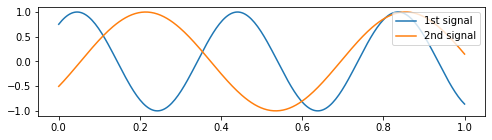

In [4]:
plt.figure(figsize=(8,2))
for i in range(2):
    plt.plot(t,x[np.random.randint(0,nt-1), :])
    plt.legend(['1st signal', '2nd signal'], loc='upper right')
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

# split into test, validation, and training sets
x_temp, x_test, _, _ = train_test_split(x, x, test_size=0.05)
x_train, x_valid, _, _ = train_test_split(x_temp,
                                          x_temp,
                                          test_size=0.1)
n_train = len(x_train)
n_valid = len(x_valid)
n_test = len(x_test)

print(n_train)
print(n_test)

25650
1500


In [6]:
bs = 300


train_set = torch.from_numpy(x)
test_set = torch.from_numpy(x_test)

train_set = train_set.float()
test_set = test_set.float()

#train_set = torch.nn.functional.normalize(train_set, p=2.0, dim=1, eps=1e-12, out=None)
#test_set = torch.nn.functional.normalize(test_set, p=2.0, dim=1, eps=1e-12, out=None)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=bs, shuffle=False)


print(train_set.shape)

torch.Size([30000, 256])


In [7]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [8]:
# build network
z_dim = 100

G = Generator(g_input_dim = z_dim, g_output_dim = nt).to(device)
D = Discriminator(nt).to(device)

In [9]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=256, bias=True)
)

In [10]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [15]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()
    #print(x.shape)
    # train discriminator on real
    #x_real, y_real = x.view(-1, nt), torch.ones(bs, 1)
    x_real, y_real = x, torch.ones(bs,1)

    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    #print(x_real.shape)
    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))
    #print(x_fake.shape)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [16]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [13]:
train_loader

In [17]:
n_epoch = 200
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx,x in enumerate(train_loader):
      #  print(len(x))
        #print(x[batch_idx,].shape)
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/200]: loss_d: 0.018, loss_g: 10.927
[2/200]: loss_d: 0.027, loss_g: 11.144
[3/200]: loss_d: 0.026, loss_g: 8.577
[4/200]: loss_d: 0.105, loss_g: 10.339
[5/200]: loss_d: 0.043, loss_g: 8.704
[6/200]: loss_d: 0.058, loss_g: 7.762
[7/200]: loss_d: 0.074, loss_g: 7.398
[8/200]: loss_d: 0.067, loss_g: 7.058
[9/200]: loss_d: 0.070, loss_g: 7.145
[10/200]: loss_d: 0.079, loss_g: 6.839
[11/200]: loss_d: 0.082, loss_g: 6.977
[12/200]: loss_d: 0.094, loss_g: 6.885
[13/200]: loss_d: 0.097, loss_g: 6.933
[14/200]: loss_d: 0.072, loss_g: 7.068
[15/200]: loss_d: 0.101, loss_g: 6.621
[16/200]: loss_d: 0.076, loss_g: 6.643
[17/200]: loss_d: 0.102, loss_g: 6.639
[18/200]: loss_d: 0.095, loss_g: 6.723
[19/200]: loss_d: 0.128, loss_g: 6.568
[20/200]: loss_d: 0.128, loss_g: 5.910
[21/200]: loss_d: 0.111, loss_g: 5.707
[22/200]: loss_d: 0.124, loss_g: 5.927
[23/200]: loss_d: 0.140, loss_g: 5.925
[24/200]: loss_d: 0.133, loss_g: 5.939
[25/200]: loss_d: 0.137, loss_g: 5.800
[26/200]: loss_d: 0.141, loss_g

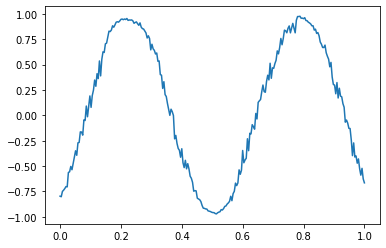

In [39]:
with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    
    z = Variable(torch.randn(z_dim).to(device))
    generated = G(z)

    y = generated.cpu().detach().numpy()

    plt.plot(t,y)

    #y = generated.view(generated.size(1))

